#### Scripts to generate proteomic analyses for Olink Gdańsk data

###### Loading necessary libraries

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import zscore
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
from IPython.display import display

###### Loading raw data

In [193]:
olink_data = pd.read_csv('/mnt/dysk_D/Olink_Gdansk/Result-X204SC25109867-Z01-F002-B1-43/1.Quant/pre_quant.csv', sep='\t')

olink_data.shape # (rows, columns)

olink_data.head() #` First 5 rows of the dataframe`

,SampleID,SampleType,WellID,PlateID,DataAnalysisRefID,OlinkID,UniProt,Assay,AssayType,Panel,...,InterCV,SampleBlockQCWarn,SampleBlockQCFail,BlockQCFail,AssayQCWarn,Group_Name1,Group_Name2,Group_Name3,Group_Name4,Group_Name5
0,P7W1,SAMPLE,A1,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,be_treatment,be_treatment,be_treatment,be_treatment,be_treatment
1,K14,SAMPLE,A2,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,control,NaN,NaN,NaN,control
2,K16,SAMPLE,A3,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,control,NaN,NaN,NaN,control
3,K18,SAMPLE,A4,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,control,NaN,NaN,NaN,control
4,P8W2,SAMPLE,A5,plate1,R10002,OID50348,Q7Z7G0,ABI3BP,assay,Reveal,...,NaN,1,1,1,1,treatment_1,treatment_1,treatment_1,NaN,NaN


###### Let's check uniqueness of some columns

In [194]:
single_unique_cols = [col for col in olink_data.columns if olink_data[col].nunique() == 1]
print(f"Columns with a single unique value: {single_unique_cols}")

Columns with a single unique value: ['PlateID', 'DataAnalysisRefID', 'AssayType', 'Panel', 'Block', 'Normalization', 'SampleQC', 'SoftwareVersion', 'SoftwareName', 'PanelDataArchiveVersion', 'PreProcessingVersion', 'PreProcessingSoftware', 'InstrumentType', 'SampleBlockQCFail', 'BlockQCFail']


In [195]:
few_unique_cols = [col for col in olink_data.columns if (olink_data[col].nunique() < 5 and olink_data[col].nunique() > 1)]
print(f"Columns with fewer than 5 unique values but more than 1: {few_unique_cols}")

Columns with fewer than 5 unique values but more than 1: ['SampleType', 'AssayQC', 'SampleBlockQCWarn', 'AssayQCWarn']


In [196]:
na_cols = olink_data.columns[olink_data.isna().any()].tolist()
print(f"Columns with missing values: {na_cols}")

Columns with missing values: ['InterCV', 'Group_Name2', 'Group_Name3', 'Group_Name4', 'Group_Name5']


###### Most of columns with one unique value are trash so we will discard them, we will also delete rows where there are missing values:

In [197]:
cols_to_drop = list(set(single_unique_cols + na_cols))
print(f"Dropping columns: {cols_to_drop}")

olink_data_cleaned = olink_data.drop(columns=cols_to_drop)

Dropping columns: ['PanelDataArchiveVersion', 'SoftwareName', 'SoftwareVersion', 'SampleQC', 'Group_Name3', 'AssayType', 'Block', 'Group_Name5', 'InstrumentType', 'DataAnalysisRefID', 'PreProcessingVersion', 'Panel', 'SampleBlockQCFail', 'Normalization', 'PlateID', 'BlockQCFail', 'InterCV', 'PreProcessingSoftware', 'Group_Name4', 'Group_Name2']


###### Let's see what we have left:

In [198]:
olink_data_cleaned.head()

,SampleID,SampleType,WellID,OlinkID,UniProt,Assay,Count,ExtNPX,NPX,PCNormalizedNPX,AssayQC,IntraCV,SampleBlockQCWarn,AssayQCWarn,Group_Name1
0,P7W1,SAMPLE,A1,OID50348,Q7Z7G0,ABI3BP,67994,1.617515,0.431347,0.935824,PASS,3.440963,1,1,be_treatment
1,K14,SAMPLE,A2,OID50348,Q7Z7G0,ABI3BP,25463,0.242791,-0.943376,-0.438900,PASS,3.440963,1,1,control
2,K16,SAMPLE,A3,OID50348,Q7Z7G0,ABI3BP,23247,0.075285,-1.110883,-0.606406,PASS,3.440963,1,1,control
3,K18,SAMPLE,A4,OID50348,Q7Z7G0,ABI3BP,25260,0.435515,-0.750653,-0.246176,PASS,3.440963,1,1,control
4,P8W2,SAMPLE,A5,OID50348,Q7Z7G0,ABI3BP,46577,1.258365,0.072197,0.576674,PASS,3.440963,1,1,treatment_1


###### We will additionaly drop last four columns and select only that rows which pass the AssayQC criterion:

In [199]:
olink_pass = olink_data_cleaned.iloc[:, list(range(olink_data_cleaned.shape[1]-4)) + [-1]] \
    [olink_data_cleaned['AssayQC'] == 'PASS'] \
    .drop(columns=['AssayQC'], errors='ignore')

olink_pass.head()

,SampleID,SampleType,WellID,OlinkID,UniProt,Assay,Count,ExtNPX,NPX,PCNormalizedNPX,Group_Name1
0,P7W1,SAMPLE,A1,OID50348,Q7Z7G0,ABI3BP,67994,1.617515,0.431347,0.935824,be_treatment
1,K14,SAMPLE,A2,OID50348,Q7Z7G0,ABI3BP,25463,0.242791,-0.943376,-0.438900,control
2,K16,SAMPLE,A3,OID50348,Q7Z7G0,ABI3BP,23247,0.075285,-1.110883,-0.606406,control
3,K18,SAMPLE,A4,OID50348,Q7Z7G0,ABI3BP,25260,0.435515,-0.750653,-0.246176,control
4,P8W2,SAMPLE,A5,OID50348,Q7Z7G0,ABI3BP,46577,1.258365,0.072197,0.576674,treatment_1


###### We should see if the distribution of NPX values resembles gaussian curve:

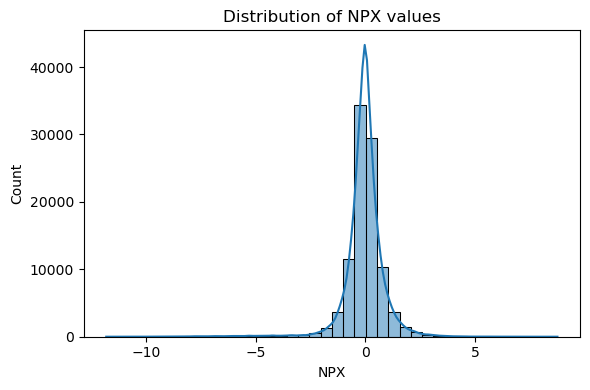

In [47]:
plt.figure(figsize=(6,4))
sns.histplot(olink_pass['NPX'], bins=40, kde=True)
plt.xlabel("NPX")
plt.ylabel("Count")
plt.title("Distribution of NPX values")
plt.tight_layout()
plt.show()

###### This boxplot show which samples are potentially outliers or if there is some batch effect (only if few of samples are not in norm)

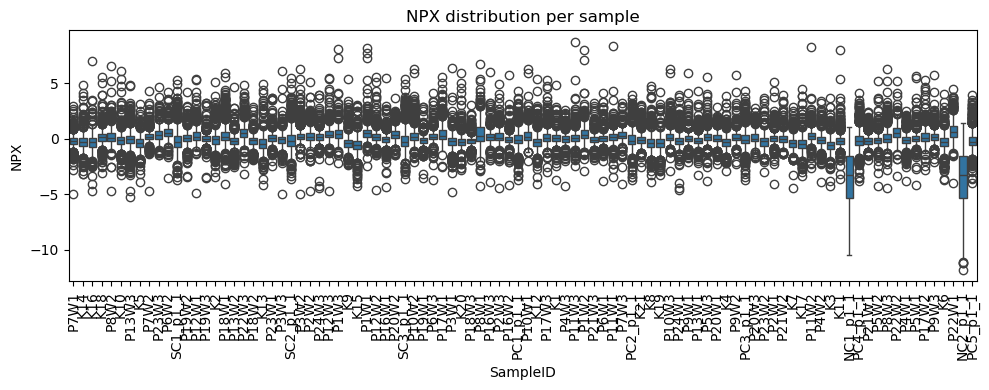

In [48]:
plt.figure(figsize=(10,4))
sns.boxplot(x='SampleID', y='NPX', data=olink_pass)
plt.xticks(rotation=90)
plt.title("NPX distribution per sample")
plt.tight_layout()
plt.show()

###### Every sample seem fine, NC1 and NC2 are negative controls so we predict their values to be lower, now let's see if normalization works:

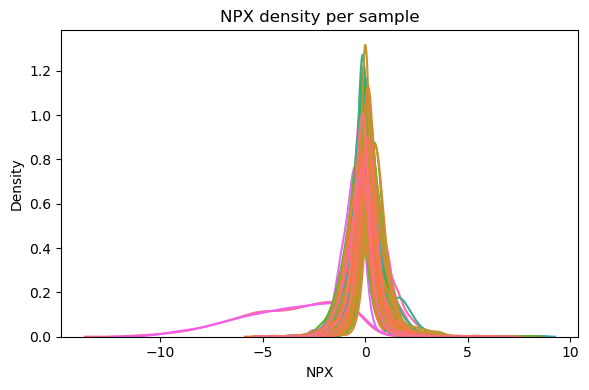

In [49]:
plt.figure(figsize=(6,4))
sns.kdeplot(
    data=olink_pass,
    x='NPX',
    hue='SampleID',
    common_norm=False,
    legend=False
)
plt.title("NPX density per sample")
plt.tight_layout()
plt.show()

In [50]:
olink_pass.groupby('SampleID')['NPX'].agg(['mean', 'std'])

,mean,std
SampleID,,
K1,0.096712,0.586367
K10,-0.101656,0.719089
K11,-0.146184,0.667938
K12,-0.323742,0.728006
K13,-0.451893,0.775077
...,...,...
PC4_p1_1,-0.122187,0.845059
PC5_p1_1,-0.193672,0.846628
SC1_p1_1,-0.171336,1.015400


###### Again, apart from negative control every density line covers so it's OK. Now for PCA and differential expression let's remove this controls from dataset:

In [200]:
olink_pass = olink_pass[~olink_pass['SampleType'].str.contains('CONTROL', na=False)]

olink_pass['SampleID'].unique().tolist()

['P7W1',
 'K14',
 'K16',
 'K18',
 'P8W2',
 'K10',
 'P13W3',
 'K5',
 'P7W2',
 'P23W3',
 'P6W2',
 'P19W2',
 'P12W1',
 'P19W3',
 'K2',
 'P18W1',
 'P13W2',
 'P22W3',
 'P18W2',
 'K13',
 'P23W1',
 'P3W3',
 'P3W2',
 'P2W2',
 'P24W3',
 'P12W3',
 'P1W3',
 'K9',
 'K15',
 'P1W1',
 'P12W2',
 'P16W1',
 'P20W2',
 'P10W2',
 'P19W1',
 'P6W3',
 'P17W1',
 'P3W1',
 'K20',
 'P18W3',
 'P8W1',
 'P16W3',
 'P2W3',
 'P16W2',
 'P10W1',
 'K12',
 'P17W3',
 'K1',
 'P4W3',
 'P11W3',
 'P1W2',
 'P21W3',
 'P6W1',
 'P11W1',
 'P7W3',
 'K21',
 'K8',
 'K19',
 'P10W3',
 'P24W1',
 'P9W1',
 'P13W1',
 'P5W3',
 'P20W1',
 'K4',
 'P9W2',
 'P20W3',
 'P23W2',
 'P2W1',
 'P21W2',
 'K7',
 'K17',
 'P11W2',
 'P4W2',
 'K3',
 'K11',
 'P21W1',
 'P5W2',
 'P8W3',
 'P22W2',
 'P4W1',
 'P5W1',
 'P17W2',
 'P9W3',
 'K6',
 'P22W1']

###### Pivot the table so we will generate PCA and heatmaps easier (protein x samples):

In [52]:
expr_mat = olink_pass.pivot_table(
    index='Assay',
    columns='SampleID',
    values='NPX'
)

###### Before the PCA, we must calculate z-score of protein expression, this will show us "which protein has the highest signal":

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
expr_z = pd.DataFrame(
    scaler.fit_transform(expr_mat.T).T,
    index=expr_mat.index,
    columns=expr_mat.columns
)

###### Finally we can do PCA:

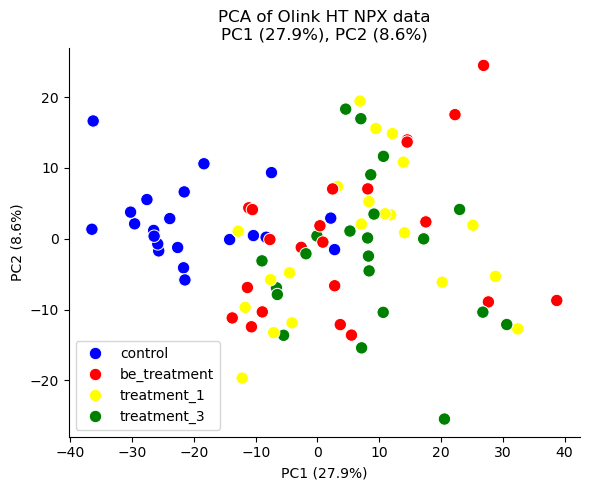

In [ ]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(expr_z.T)


pca_df = pd.DataFrame(
    pcs,
    columns=['PC1', 'PC2'],
    index=expr_z.columns
)

meta_df = (
    olink_pass[['SampleID', 'Group_Name1']]
    .drop_duplicates()
    .set_index('SampleID')
)



pca_df = pca_df.join(meta_df)


palette = {
    'control': 'blue',
    'be_treatment': 'red',
    'treatment_1': 'yellow',
    'treatment_3': 'green'
}


plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Group_Name1',
    palette=palette,
    s=80,       
    alpha=1     
)
plt.title(
    f"PCA of Olink HT NPX data\nPC1 ({pca.explained_variance_ratio_[0]*100:.1f}%), "
    f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)"
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title='')  
sns.despine()
plt.tight_layout()
plt.show()

###### We will take a closer look at the extremes of two main principal components:

In [64]:
pca_df.reset_index().sort_values('PC1')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].head(5)

,SampleID,PC1,PC2,Group_Name1
14,K3,-36.516542,1.341041,control
6,K15,-36.309736,16.636219,control
8,K17,-30.252134,3.758816,control
4,K13,-29.598095,2.110817,control
10,K19,-27.609622,5.538398,control


In [66]:
pca_df.reset_index().sort_values('PC1')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].tail(5)

,SampleID,PC1,PC2,Group_Name1
45,P1W1,27.661474,-8.921014,be_treatment
75,P6W2,28.807271,-5.319490,treatment_1
56,P22W3,30.628121,-12.117089,treatment_3
55,P22W2,32.412615,-12.733345,treatment_1
54,P22W1,38.727965,-8.720123,be_treatment


In [65]:
pca_df.reset_index().sort_values('PC2')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].head(5)

,SampleID,PC1,PC2,Group_Name1
59,P23W3,20.547248,-25.469624,treatment_3
58,P23W2,-12.194732,-19.683170,treatment_1
50,P20W3,7.141182,-15.413032,treatment_3
67,P3W3,-5.486066,-13.639552,treatment_3
57,P23W1,5.500286,-13.611975,be_treatment


In [67]:
pca_df.reset_index().sort_values('PC2')[['SampleID', 'PC1', 'PC2', 'Group_Name1']].tail(5)

,SampleID,PC1,PC2,Group_Name1
82,P8W3,7.016024,16.958689,treatment_3
36,P17W1,22.255168,17.533137,be_treatment
38,P17W3,4.563778,18.311756,treatment_3
37,P17W2,6.879549,19.442753,treatment_1
80,P8W1,26.884143,24.487169,be_treatment


###### As we can observe there is no sample with outstanding high or low variation, we will not exclude any sample. Now let's move to differential analysis

In [201]:
group_map = {
    'control': 'Control',
    'be_treatment': 'Treatment',
    'treatment_1': 'Treatment',
    'treatment_3': 'Treatment'
}

olink_pass['Group_simple'] = olink_pass['Group_Name1'].map(group_map)
#olink_pass['Group_simple'].value_counts()

olink_long = (
    olink_pass[['Assay', 'SampleID', 'NPX', 'Group_simple']].dropna(subset=['Group_simple']) 
)

###### Now that we have two groups (control vs treatment) we cab actually make diff analysis:

In [75]:
results = []

for assay, df_a in olink_long.groupby('Assay'):
    ctrl = df_a.loc[df_a['Group_simple'] == 'Control', 'NPX']
    trt  = df_a.loc[df_a['Group_simple'] == 'Treatment', 'NPX']

    if len(ctrl) < 2 or len(trt) < 2:
        continue

    t_stat, p_val = ttest_ind(trt, ctrl, nan_policy='omit')

    results.append({
        'Assay': assay,
        'mean_Treatment': trt.mean(),
        'mean_Control': ctrl.mean(),
        'lfc': trt.mean() - ctrl.mean(),
        't_stat': t_stat,
        'p_value': p_val
    })

diff_results = pd.DataFrame(results)

diff_results['fdr'] = multipletests(
    diff_results['p_value'],
    method='fdr_bh'
)[1]

diff_results = diff_results.sort_values('fdr')

diff_results.head()

,Assay,mean_Treatment,mean_Control,lfc,t_stat,p_value,fdr
314,EDA2R,0.255216,-1.363359,1.618575,12.182957,2.944262e-20,3.038479e-17
301,DPY30,0.141529,-0.868658,1.010187,11.999968,6.636256e-20,3.424308e-17
459,IFI30,0.192247,-1.488408,1.680655,11.038136,5.016513e-18,1.725680e-15
452,HSPB6,0.161784,-0.829121,0.990905,10.459065,7.042832e-17,1.817051e-14
554,KLRF1,0.127361,-0.810486,0.937848,10.352553,1.147872e-16,2.369209e-14


###### Let's visualize diff_result matrix by volcano plot:

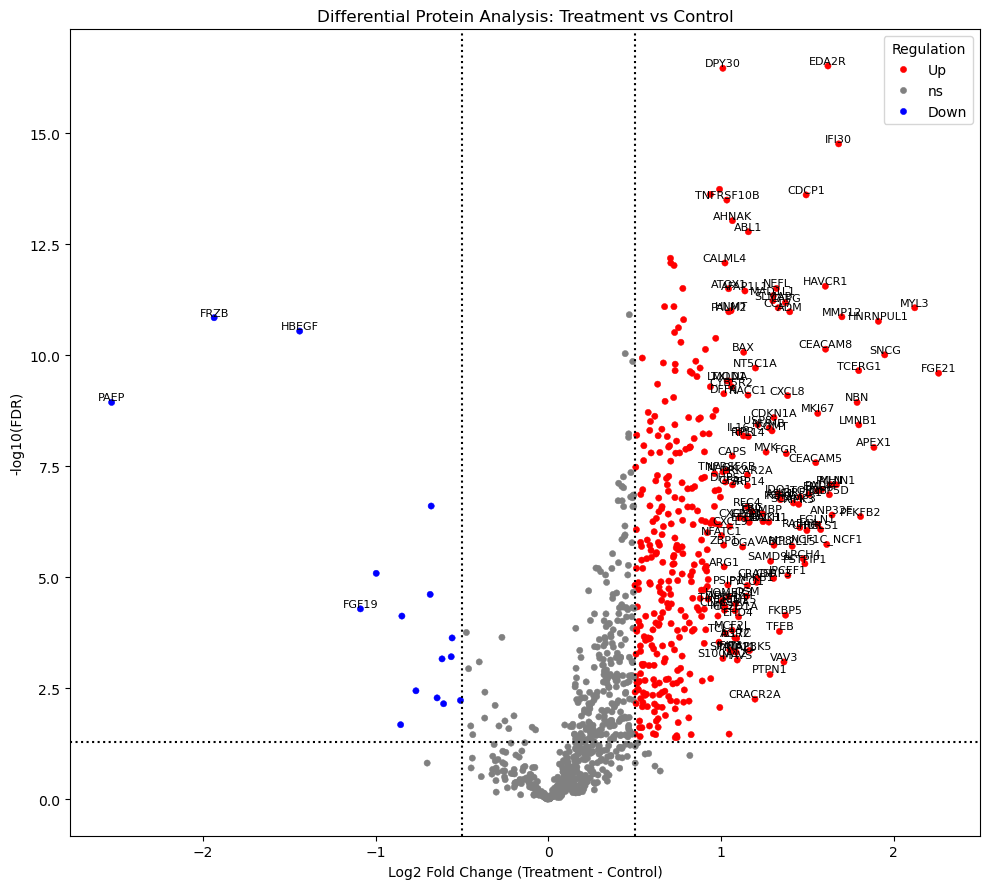

In [79]:
diff_results['neglog10_fdr'] = -np.log10(diff_results['fdr'])

diff_results['Regulation'] = np.where(
    (diff_results['fdr'] >= 0.05) | (diff_results['lfc'].abs() <= 0.5),
    'ns',
    np.where(diff_results['lfc'] > 0.5, 'Up', 'Down')
)

palette = {
    'Up': 'red',
    'Down': 'blue',
    'ns': 'grey'
}


plt.figure(figsize=(10,9))

sns.scatterplot(
    data=diff_results,
    x='lfc',
    y='neglog10_fdr',
    hue='Regulation',
    palette=palette,
    s=20,
    edgecolor=None
)


plt.axhline(-np.log10(0.05), linestyle='dotted', color='black')
plt.axvline(0.5, linestyle='dotted', color='black')
plt.axvline(-0.5, linestyle='dotted', color='black')

label_df = diff_results.query("fdr < 0.01 and abs(lfc) > 1")

for _, row in label_df.iterrows():
    plt.text(
        row['lfc'],
        row['neglog10_fdr'],
        row['Assay'],
        fontsize=8,
        ha='center',
        va='bottom'
    )


plt.title("Differential Protein Analysis: Treatment vs Control")
plt.xlabel("Log2 Fold Change (Treatment - Control)")
plt.ylabel("-log10(FDR)")
plt.legend(title="Regulation")
plt.tight_layout()
plt.show()

###### Summary with table for fdr < 0.05

In [80]:
reg_summary_fdr = (
    diff_results
    .assign(
        Regulation=lambda df: np.where(
            (df['fdr'] < 0.05) & (df['lfc'] > 0), 'Up',
            np.where(
                (df['fdr'] < 0.05) & (df['lfc'] < 0), 'Down',
                'ns'
            )
        )
    )
    .query("Regulation != 'ns'")
    .groupby('Regulation', as_index=False)
    .size()
    .rename(columns={'size': 'n_genes'})
    .sort_values('Regulation')
)

reg_summary_fdr

,Regulation,n_genes
0,Down,31
1,Up,638


###### and with |lfc| > 0.5

In [81]:
reg_summary_fdr_lfc = (
    diff_results
    .assign(
        Regulation=lambda df: np.where(
            (df['fdr'] < 0.05) & (df['lfc'] > 0.5), 'Up',
            np.where(
                (df['fdr'] < 0.05) & (df['lfc'] < -0.5), 'Down',
                'ns'
            )
        )
    )
    .query("Regulation != 'ns'")
    .groupby('Regulation', as_index=False)
    .size()
    .rename(columns={'size': 'n_genes'})
    .sort_values('Regulation')
)

reg_summary_fdr_lfc

,Regulation,n_genes
0,Down,16
1,Up,408


###### Lastly we will add heatmap with clustered samples and top most variable proteins

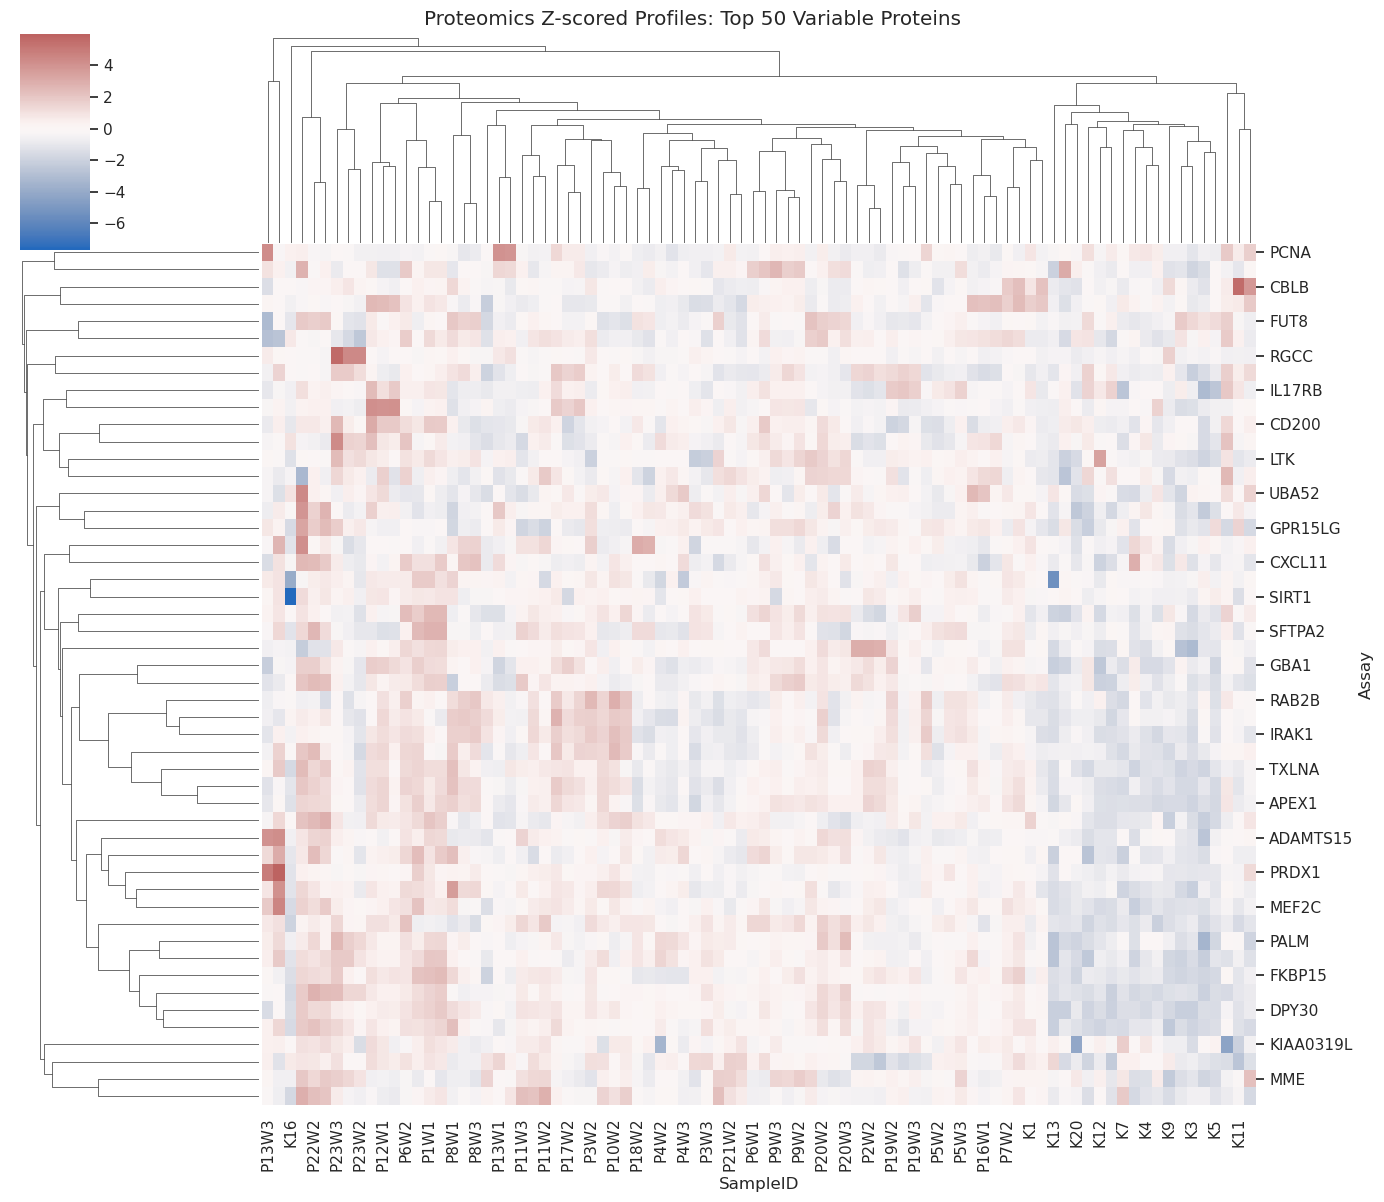

In [ ]:
heatmap_df = olink_pass.pivot(index='Assay', columns='SampleID', values='PCNormalizedNPX')

heatmap_z = pd.DataFrame(
    zscore(heatmap_df.values, axis=1, nan_policy='omit'),
    index=heatmap_df.index,
    columns=heatmap_df.columns
)

top_var = heatmap_z.var(axis=1).sort_values(ascending=False).head(50).index
heatmap_top = heatmap_z.loc[top_var]
sns.set(style="white")
g = sns.clustermap(
    heatmap_top,
    cmap='vlag',
    row_cluster=True,
    col_cluster=True,
    center=0,
    figsize=(14,12)
)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
g.fig.suptitle("Proteomics Z-scored Profiles: Top 50 Variable Proteins", y=1.00)
plt.show()

###### This part is about doing analyses corrected by age and gender

In [182]:
df_control_meta = pd.read_excel('/mnt/dysk_D/Olink_Gdansk/OLINK_CONTROL_LIST.xlsx')

df_k_olink = pd.DataFrame({
    'OLINK number': 'K' + df_control_meta['Number'].astype(str),
    'Age': df_control_meta['Age'],
    'Gender': df_control_meta['Sex']
})

df_k_olink.head()

,OLINK number,Age,Gender
0,K1,29,F
1,K2,42,F
2,K3,42,F
3,K4,25,M
4,K5,46,M


In [189]:
df_metadata = pd.read_excel('/mnt/dysk_D/Olink_Gdansk/hf_flozins_database.xlsx', header=2)

df_metadata = df_metadata.iloc[:, 1:5]

df_metadata = df_metadata.drop(df_metadata.columns[1], axis=1)

df_metadata = df_metadata.iloc[:24]

df_metadata.head(30)

,OLINK number,Age,Gender
0,P1,73.0,F
1,P2,67.0,M
2,P3,76.0,F
3,P4,67.0,F
4,P5,84.0,M
5,P6,76.0,F
6,P7,72.0,F
7,P8,70.0,F
8,P9,67.0,F
9,P10,74.0,F


In [190]:
df_combined_meta = pd.concat(
    [df_metadata, df_k_olink],
    ignore_index=True
)

df_combined_meta.head(30)

,OLINK number,Age,Gender
0,P1,73.0,F
1,P2,67.0,M
2,P3,76.0,F
3,P4,67.0,F
4,P5,84.0,M
5,P6,76.0,F
6,P7,72.0,F
7,P8,70.0,F
8,P9,67.0,F
9,P10,74.0,F


In [202]:
olink_pass

,SampleID,SampleType,WellID,OlinkID,UniProt,Assay,Count,ExtNPX,NPX,PCNormalizedNPX,Group_Name1,Group_simple
0,P7W1,SAMPLE,A1,OID50348,Q7Z7G0,ABI3BP,67994,1.617515,0.431347,0.935824,be_treatment,Treatment
1,K14,SAMPLE,A2,OID50348,Q7Z7G0,ABI3BP,25463,0.242791,-0.943376,-0.438900,control,Control
2,K16,SAMPLE,A3,OID50348,Q7Z7G0,ABI3BP,23247,0.075285,-1.110883,-0.606406,control,Control
3,K18,SAMPLE,A4,OID50348,Q7Z7G0,ABI3BP,25260,0.435515,-0.750653,-0.246176,control,Control
4,P8W2,SAMPLE,A5,OID50348,Q7Z7G0,ABI3BP,46577,1.258365,0.072197,0.576674,treatment_1,Treatment
...,...,...,...,...,...,...,...,...,...,...,...,...
99257,P5W1,SAMPLE,H6,OID51014,Q8WV99,ZFAND2B,11870,-0.901159,0.044955,0.227414,be_treatment,Treatment
99258,P17W2,SAMPLE,H7,OID51014,Q8WV99,ZFAND2B,9138,-1.194795,-0.248681,-0.066222,treatment_1,Treatment
99259,P9W3,SAMPLE,H8,OID51014,Q8WV99,ZFAND2B,9200,-0.907142,0.038972,0.221431,treatment_3,Treatment
99260,K6,SAMPLE,H9,OID51014,Q8WV99,ZFAND2B,8692,-1.238989,-0.292876,-0.110417,control,Control


In [203]:
olink_pass['OLINK_number_clean'] = (
    olink_pass['SampleID']
    .str.extract(r'([PK]\d+)')   # P7W1 -> P7, K6 -> K6
)

olink_pass = olink_pass.merge(
    df_combined_meta[['OLINK number', 'Age', 'Gender']],
    left_on='OLINK_number_clean',
    right_on='OLINK number',
    how='left'
)


olink_pass = olink_pass.drop(columns=['OLINK number'])

olink_pass.head(30)

,SampleID,SampleType,WellID,OlinkID,UniProt,Assay,Count,ExtNPX,NPX,PCNormalizedNPX,Group_Name1,Group_simple,OLINK_number_clean,Age,Gender
0,P7W1,SAMPLE,A1,OID50348,Q7Z7G0,ABI3BP,67994,1.617515,0.431347,0.935824,be_treatment,Treatment,P7,72.0,F
1,K14,SAMPLE,A2,OID50348,Q7Z7G0,ABI3BP,25463,0.242791,-0.943376,-0.438900,control,Control,K14,46.0,M
2,K16,SAMPLE,A3,OID50348,Q7Z7G0,ABI3BP,23247,0.075285,-1.110883,-0.606406,control,Control,K16,29.0,F
3,K18,SAMPLE,A4,OID50348,Q7Z7G0,ABI3BP,25260,0.435515,-0.750653,-0.246176,control,Control,K18,27.0,M
4,P8W2,SAMPLE,A5,OID50348,Q7Z7G0,ABI3BP,46577,1.258365,0.072197,0.576674,treatment_1,Treatment,P8,70.0,F
5,K10,SAMPLE,A6,OID50348,Q7Z7G0,ABI3BP,32149,0.860047,-0.326121,0.178356,control,Control,K10,29.0,F
6,P13W3,SAMPLE,A7,OID50348,Q7Z7G0,ABI3BP,45247,1.007705,-0.178463,0.326014,treatment_3,Treatment,P13,72.0,F
7,K5,SAMPLE,A8,OID50348,Q7Z7G0,ABI3BP,23550,0.165544,-1.020624,-0.516147,control,Control,K5,46.0,M
8,P7W2,SAMPLE,A9,OID50348,Q7Z7G0,ABI3BP,73445,1.958049,0.771881,1.276358,treatment_1,Treatment,P7,72.0,F
9,P23W3,SAMPLE,A10,OID50348,Q7Z7G0,ABI3BP,125282,2.934379,1.748212,2.252688,treatment_3,Treatment,P23,84.0,F


###### Let's check the statistical data of 'age' column:

In [204]:
olink_pass['Age'].describe()

count    88752.000000
mean        63.081395
std         17.425164
min         24.000000
25%         60.000000
50%         69.000000
75%         74.000000
max         84.000000
Name: Age, dtype: float64

###### Now we will do age and gender corrected differential analysis:

###### First analysis: Control vs Treatment (age and gender corrected), from smf.ols method:

In [206]:
results = []

for protein, sub in df.groupby("Assay"):
    if sub["Group_simple"].nunique() < 2:
        continue  # bo statystyka też ma uczucia

    model = smf.ols(
        formula="NPX ~ Group_simple + Age + Gender",
        data=sub
    ).fit()

    coef = model.params["Group_simple[T.Treatment]"]
    pval = model.pvalues["Group_simple[T.Treatment]"]

    results.append({
        "Assay": protein,
        "logFC": coef,          # to jest dokładnie log2FC
        "pvalue": pval,
        "n": len(sub)
    })
    
res = pd.DataFrame(results)

res["padj"] = multipletests(
    res["pvalue"],
    method="fdr_bh"
)[1]

res = res.sort_values("padj")
res.head()

,Assay,logFC,pvalue,n,padj
124,CAPG,1.922273,0.000002,86,0.001269
931,TCERG1,2.891347,0.000002,86,0.001269
442,HNRNPUL1,2.739435,0.000005,86,0.001375
767,PSIP1,2.436200,0.000005,86,0.001375
999,USP8,1.965450,0.000009,86,0.001537


###### Adding modified vulcano-plot:

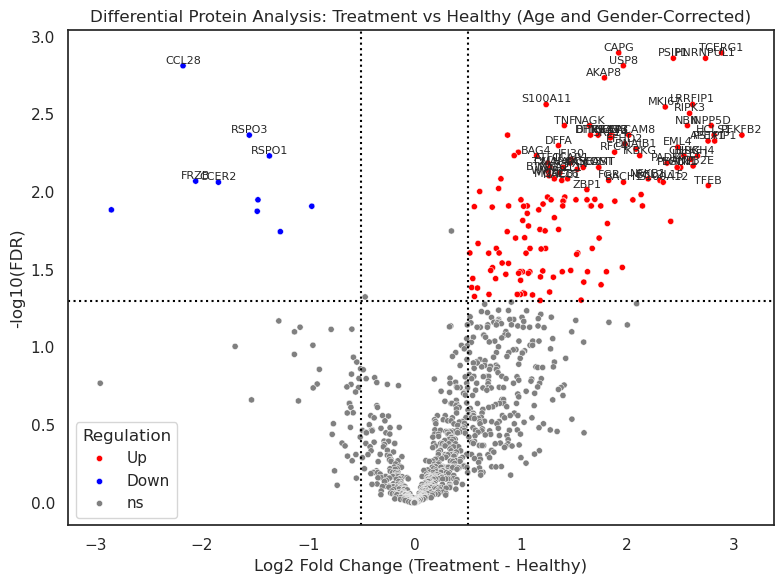

In [207]:
def regulation_color(row):
    if row['padj'] >= 0.05 or abs(row['logFC']) <= 0.5:
        return 'ns'
    elif row['logFC'] > 0.5:
        return 'Up'
    elif row['logFC'] < -0.5:
        return 'Down'
    else:
        return 'ns'

res['Regulation'] = res.apply(regulation_color, axis=1)

palette = {'Up': 'red', 'Down': 'blue', 'ns': 'grey'}


plt.figure(figsize=(8,6))
sns.scatterplot(
    data=res,
    x='logFC',
    y=-np.log10(res['padj']),
    hue='Regulation',
    palette=palette,
    s=20,      
    alpha=1
)


for _, row in res[(res['padj'] < 0.01) & (abs(res['logFC']) > 1)].iterrows():
    plt.text(row['logFC'], -np.log10(row['padj']), row['Assay'],
             fontsize=8, ha='center', va='bottom')


plt.axhline(-np.log10(0.05), linestyle='dotted', color='black')
plt.axvline(0.5, linestyle='dotted', color='black')
plt.axvline(-0.5, linestyle='dotted', color='black')

plt.title("Differential Protein Analysis: Treatment vs Healthy (Age and Gender-Corrected)")
plt.xlabel("Log2 Fold Change (Treatment - Healthy)")
plt.ylabel("-log10(FDR)")
plt.legend(title='Regulation')
plt.tight_layout()
plt.show()

###### And up/down-regulated proteins:

In [253]:
reg_summary_all = pd.DataFrame({
    "Dataset": [
        "FDR < 0.05",
        "FDR < 0.05 & |LFC| > 0.5",
        "FDR < 0.05 Age-corrected, limma-method",
        "FDR < 0.05 & |LFC| > 0.5 Age-corrected, limma-method"
    ],
    "Up": [
        ((diff_results['fdr'] < 0.05) & (diff_results['lfc'] > 0)).sum(),
        ((diff_results['fdr'] < 0.05) & (diff_results['lfc'] > 0.5)).sum(),
        ((res['padj'] < 0.05) & (res['logFC'] > 0)).sum(),
        ((res['padj'] < 0.05) & (res['logFC'] > 0.5)).sum()
    ],
    "Down": [
        ((diff_results['fdr'] < 0.05) & (diff_results['lfc'] < 0)).sum(),
        ((diff_results['fdr'] < 0.05) & (diff_results['lfc'] < -0.5)).sum(),
        ((res['padj'] < 0.05) & (res['logFC'] < 0)).sum(),
        ((res['padj'] < 0.05) & (res ['logFC'] < -0.5)).sum()
    ]
})

print("Summary of Up- and Down-regulated Proteins")
display(reg_summary_all)


Summary of Up- and Down-regulated Proteins


,Dataset,Up,Down
0,FDR < 0.05,638,31
1,FDR < 0.05 & |LFC| > 0.5,408,16
2,"FDR < 0.05 Age-corrected, limma-method",152,11
3,"FDR < 0.05 & |LFC| > 0.5 Age-corrected, limma-...",151,10


###### On this plot we should see the differences between lfc before and after age and gender correction:

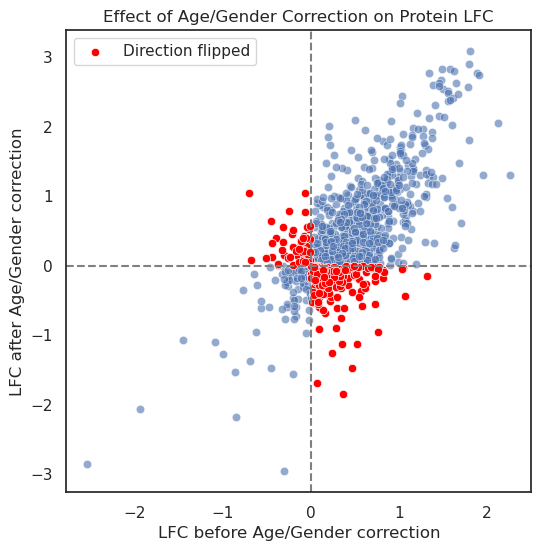

In [211]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=diff_results['lfc'],
    y=res['logFC'],
    alpha=0.6
)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('LFC before Age/Gender correction')
plt.ylabel('LFC after Age/Gender correction')
plt.title('Effect of Age/Gender Correction on Protein LFC')


flip_idx = (diff_results['lfc'] * res['logFC']) < 0
sns.scatterplot(
    x=diff_results.loc[flip_idx, 'lfc'],
    y=res.loc[flip_idx, 'logFC'],
    color='red',
    label='Direction flipped'
)

plt.legend()
plt.show()

###### In this part final we will save important (after corrections and with logfc and fdr thresholds) up- and down-regulated genes to a csv list

In [212]:
threshold_fdr = 0.05
threshold_lfc = 0.5



threshold_fdr = 0.05
threshold_lfc = 0.5


res['regulation'] = np.where(
    (res['padj'] < threshold_fdr) & (res['logFC'] > threshold_lfc), 'Up',
    np.where(
        (res['padj'] < threshold_fdr) & (res['logFC'] < -threshold_lfc),
        'Down',
        None  
    )
)


genes_filtered = res.dropna(subset=['regulation'])


genes_table = genes_filtered[['Assay', 'regulation']].rename(columns={'Assay': 'gene'})


print(genes_table)

genes_table.to_csv('up_down_genes_age_corrected_v2.csv', index=False)

         gene regulation
124      CAPG         Up
931    TCERG1         Up
442  HNRNPUL1         Up
767     PSIP1         Up
999      USP8         Up
..        ...        ...
176      CD63         Up
855  SERPINB8         Up
926   TACSTD2         Up
988      TYMS         Up
120  CALCOCO2         Up

[161 rows x 2 columns]


###### Now we will do paired-analysis of treatment specifics (before_treatment vs treatment_1 and vs treatment_3):

In [ ]:
def paired_diffexp(df, group_a, group_b):
    results = []

    df_sub = df[df['Group_Name1'].isin([group_a, group_b])].copy()

    for assay in df_sub['Assay'].unique():
        tmp = df_sub[df_sub['Assay'] == assay]

        
        wide = tmp.pivot_table(
            index='OLINK_number_clean',
            columns='Group_Name1',
            values='NPX'
        ).dropna()  

        
        if wide.shape[0] < 3:
            wide.describe()
            continue  

       
        stat, pval = ttest_rel(wide[group_b], wide[group_a])

        lfc = (wide[group_b] - wide[group_a]).mean()

        results.append({
            'Assay': assay,
            'lfc': lfc,
            'pvalue': pval
        })

    res = pd.DataFrame(results)
    res['fdr'] = multipletests(res['pvalue'], method='fdr_bh')[1]

    return res.sort_values('fdr')

In [235]:
deg_be_vs_t1 = paired_diffexp(
    olink_pass,
    group_a='be_treatment',
    group_b='treatment_1'
)

In [250]:
deg_be_vs_t1.head(50)

,Assay,lfc,pvalue,fdr
86,BCAN,0.146789,0.002080,0.429259
841,SCARB2,0.164072,0.001380,0.429259
626,MMP10,0.256356,0.001124,0.429259
562,LAIR2,0.133630,0.000738,0.429259
167,CD300E,0.175694,0.001847,0.429259
665,NECAB2,0.128256,0.006409,0.549956
73,ATRAID,0.153286,0.004297,0.549956
699,OCLN,0.152411,0.004872,0.549956
955,TNFRSF10A,0.128383,0.007358,0.549956
428,HAVCR1,0.270047,0.004700,0.549956


In [236]:
deg_be_vs_t3 = paired_diffexp(
    olink_pass,
    group_a='be_treatment',
    group_b='treatment_3'
)

In [251]:
deg_be_vs_t3.head(50)

,Assay,lfc,pvalue,fdr
167,CD300E,0.295266,0.000029,0.030196
956,TNFRSF10B,0.185210,0.000147,0.041112
698,OBP2B,0.205542,0.000199,0.041112
562,LAIR2,0.170299,0.000122,0.041112
220,CLEC7A,0.194169,0.000195,0.041112
800,RAET1L_ULBP2,0.185198,0.000287,0.042813
174,CD5,0.138813,0.000290,0.042813
73,ATRAID,0.203505,0.000343,0.044311
699,OCLN,0.203721,0.000538,0.061689
963,TNFRSF9,0.181174,0.000676,0.069811


###### For every comparison we plot vulcanoplot:

In [237]:
def volcano_plot(df, title):
    df = df.copy()
    df['regulation'] = 'ns'
    df.loc[(df['fdr'] < 0.05) & (df['lfc'] > 0.5), 'regulation'] = 'Up'
    df.loc[(df['fdr'] < 0.05) & (df['lfc'] < -0.5), 'regulation'] = 'Down'

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df,
        x='lfc',
        y=-np.log10(df['fdr']),
        hue='regulation',
        palette={'Up': 'red', 'Down': 'blue', 'ns': 'grey'},
        s=15,
        linewidth=0
    )

    plt.axhline(-np.log10(0.05), ls='dotted', c='black')
    plt.axvline(0.5, ls='dotted', c='black')
    plt.axvline(-0.5, ls='dotted', c='black')

    plt.title(title)
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(FDR)')
    plt.legend(title='Regulation')
    plt.tight_layout()
    plt.show()

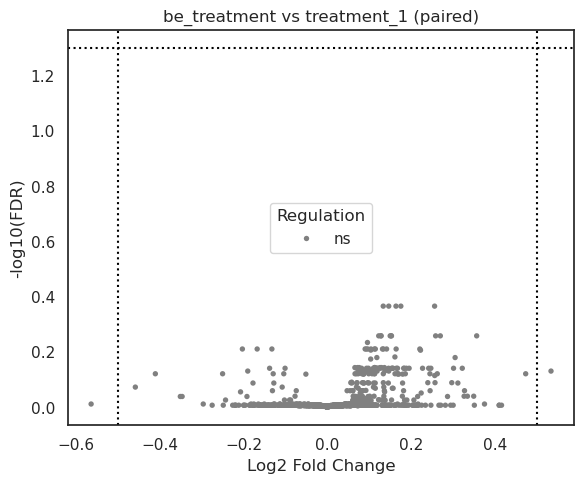

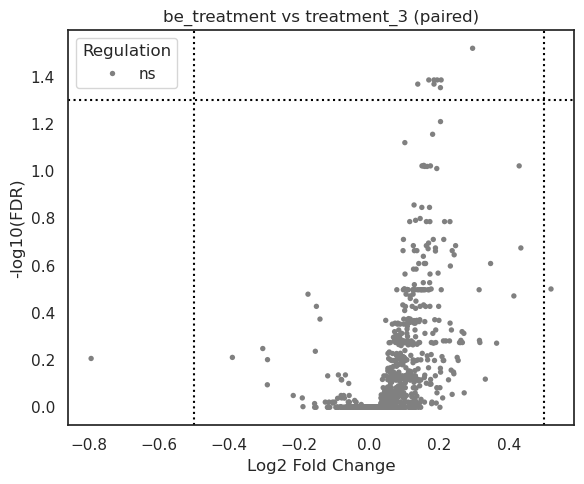

In [238]:
volcano_plot(deg_be_vs_t1, 'be_treatment vs treatment_1 (paired)')
volcano_plot(deg_be_vs_t3, 'be_treatment vs treatment_3 (paired)')

###### No differences here, let's check paired analysis after age and gender correction:

In [ ]:
comparisons = [
    ("be_treatment", "treatment_1"),
    ("be_treatment", "treatment_3")
]

results_all = []

for group_a, group_b in comparisons:
    df_sub = olink_pass[olink_pass['Group_Name1'].isin([group_a, group_b])].copy()
    
    for assay in df_sub['Assay'].unique():
        tmp = df_sub[df_sub['Assay'] == assay]
        
        # pivot: PatientID x condition
        wide = tmp.pivot_table(
            index='OLINK_number_clean',  
            columns='Group_Name1',
            values='NPX'
        )
        
        
        if wide.shape[1] < 2:
            print(f"Skipping {assay}: missing group values")
            continue

        
        covariates = tmp.groupby('OLINK_number_clean')[['Age', 'Gender']].first()
        wide = wide.join(covariates)
        
        
        long_df = wide.reset_index().melt(
            id_vars=['OLINK_number_clean', 'Age', 'Gender'],
            value_vars=[group_a, group_b],
            var_name='Group',
            value_name='NPX'
        )
        
       
        long_df['OLINK_number_clean'] = long_df['OLINK_number_clean'].astype('category')
        long_df['Group'] = long_df['Group'].astype('category')
        long_df['Gender'] = long_df['Gender'].astype('category')
        
        
        model = smf.ols("NPX ~ C(Group) + Age + C(Gender) + C(OLINK_number_clean)", data=long_df).fit()
        
       
        coef_name = f"C(Group)[T.{group_b}]"
        if coef_name in model.params:
            estimate = model.params[coef_name]
            pvalue = model.pvalues[coef_name]
            results_all.append({
                'Assay': assay,
                'Comparison': f"{group_a} vs {group_b}",
                'lfc': estimate,
                'pvalue': pvalue
            })


deg_paired = pd.DataFrame(results_all)


deg_paired['fdr'] = multipletests(deg_paired['pvalue'], method='fdr_bh')[1]


lfc_thresh = 0.5
fdr_thresh = 0.05

deg_paired['regulation'] = np.where(
    (deg_paired['fdr'] < fdr_thresh) & (deg_paired['lfc'] > lfc_thresh), 'Up',
    np.where((deg_paired['fdr'] < fdr_thresh) & (deg_paired['lfc'] < -lfc_thresh), 'Down', None)
)


deg_paired_sig = deg_paired.dropna(subset=['regulation'])

In [249]:
deg_paired.head(50)

,Assay,Comparison,lfc,pvalue,fdr,regulation
0,ABI3BP,be_treatment vs treatment_1,0.032033,0.587820,0.996933,ns
1,ABL1,be_treatment vs treatment_1,0.103086,0.456339,0.985736,ns
2,ACAA1,be_treatment vs treatment_1,0.046632,0.682436,0.996933,ns
3,ACAN,be_treatment vs treatment_1,-0.003152,0.925485,0.996933,ns
4,ACE2,be_treatment vs treatment_1,0.035018,0.379841,0.952892,ns
5,ACP1,be_treatment vs treatment_1,-0.092692,0.759000,0.996933,ns
6,ACP3,be_treatment vs treatment_1,0.094247,0.244414,0.856880,ns
7,ACP6,be_treatment vs treatment_1,0.047588,0.337651,0.932867,ns
8,ACRV1,be_treatment vs treatment_1,-0.056362,0.630415,0.996933,ns
9,ACVRL1,be_treatment vs treatment_1,0.061171,0.127823,0.722033,ns


###### At the end we can plot vulcanoplots to this paired analysis:

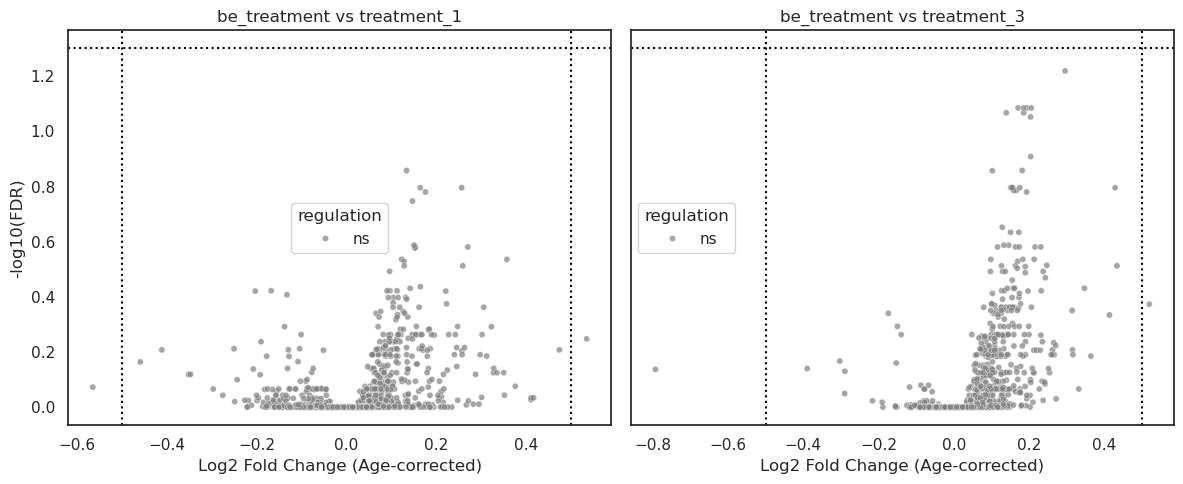

In [ ]:
lfc_thresh = 0.5
fdr_thresh = 0.05


deg_paired['regulation'] = np.where(
    (deg_paired['fdr'] < fdr_thresh) & (deg_paired['lfc'] > lfc_thresh), 'Up',
    np.where((deg_paired['fdr'] < fdr_thresh) & (deg_paired['lfc'] < -lfc_thresh), 'Down', 'ns')
)

#
comparisons = deg_paired['Comparison'].unique()
fig, axes = plt.subplots(1, len(comparisons), figsize=(12, 5), sharey=True)

for ax, comp in zip(axes, comparisons):
    df = deg_paired[deg_paired['Comparison'] == comp]
    
    sns.scatterplot(
        data=df,
        x='lfc',
        y=-np.log10(df['fdr']),
        hue='regulation',
        palette={'Up': 'red', 'Down': 'blue', 'ns': 'grey'},
        ax=ax,
        s=20,
        alpha=0.7
    )
    
    # Dodaj linie threshold
    ax.axhline(-np.log10(fdr_thresh), color='black', linestyle='dotted')
    ax.axvline(lfc_thresh, color='black', linestyle='dotted')
    ax.axvline(-lfc_thresh, color='black', linestyle='dotted')
    
    ax.set_title(comp)
    ax.set_xlabel("Log2 Fold Change")
    ax.set_ylabel("-log10(FDR)")

plt.tight_layout()
plt.show()